In [77]:
import pandas as pd
import numpy as np
import glob
import ast
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
glob.glob('viz/*.csv')

['viz\\2018-09-12 - Consolidated Entity Data - Indonesia.csv',
 'viz\\2018-09-17 - Consolidated Entity Relationship Data - Indonesia.csv',
 'viz\\ctd-template.csv',
 'viz\\ctd-test.csv',
 'viz\\kumu - elements.csv',
 'viz\\kumu - relationships.csv']

In [3]:
df_rel = pd.read_csv('viz\\2018-09-17 - Consolidated Entity Relationship Data - Indonesia.csv')
df_el = pd.read_csv('viz\\2018-09-12 - Consolidated Entity Data - Indonesia.csv')

C:\Users\admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,4,5,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,29,30,31,32,33,34,35,36,37,39,40,44,45,46,47,48,51,52,53,54,55,56,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,77,78,79,80,81,82,83,84,85,87,88,89,90,91,92,94,95,96,97,98,99,100,101,102,105,106,107,108,109,110,112,113,114,115,116,117,119,120,121,122,123,124,125,126,127,128,142,143,145,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean relationships table

In [4]:
rel_rename = {
    'destination_entity_name': "To",
    'source_entity_name': "From",
    'relationship_type': "Type",
}

In [5]:
df_rel = df_rel.rename(columns=rel_rename)

In [6]:
df_rel = df_rel[['From', 'To', 'Type','entity_data_source',
       'source_entity_type',  'destination_entity_type']]

In [7]:
df_rel_shortlist = df_rel[(df_rel['To'].notnull()) & (df_rel['From'].notnull())].reset_index(drop=True)

In [55]:
df_rel_geo = df_rel_shortlist[(df_rel_shortlist['Type'].isin(['is_investor_of'])) & (df_rel_shortlist['entity_data_source'] == 'Startup Ranking (investor)')]

In [88]:
df_rel_geo = df_rel_geo.append(df_rel_shortlist[(df_rel_shortlist['Type'].isin(['is_investor_of']))].head(100))

In [89]:
df_rel_geo.shape

(106, 6)

In [90]:
df_rel_geo.to_csv('viz\\kumu - relationships - GEO.csv', index=False)

## Clean elements table

In [91]:
df_from = df_rel_geo[['From','source_entity_type', 'entity_data_source']].rename(columns={'From':'Label', 'source_entity_type':'Type'})
df_to = df_rel_geo[['To','destination_entity_type', 'entity_data_source']].rename(columns={'To':'Label', 'destination_entity_type': 'Type'})

In [92]:
df_from.shape, df_to.shape

((106, 3), (106, 3))

In [93]:
df_rel_lookup = pd.concat([df_from,df_to]).drop_duplicates()

In [94]:
el_cols = ['Label', 'Type', 'entity_data_source']
df_el_shortlist = df_rel_lookup.merge(df_el, how='left', on=el_cols)

In [95]:
df_el_shortlist.shape, df_el_shortlist[df_el_shortlist['Label'].notnull()].reset_index(drop=True).shape

((110, 149), (110, 149))

In [96]:
df_el_shortlist = df_el_shortlist[df_el_shortlist['Label'].notnull()].reset_index(drop=True)

(array([  3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 146.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

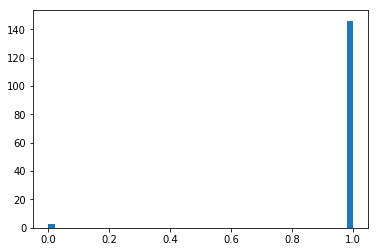

In [97]:
plt.hist(df_el_shortlist.isnull().mean(), bins=50)

In [98]:
# replace Industry list
df_el_shortlist['entity_industry_list'] = df_el_shortlist['entity_industry_list'].str.replace('[', '').str.replace(']', '').str.replace("'", '')
df_el_shortlist['entity_industry_list'] = df_el_shortlist['entity_industry_list'].str.replace(', or ', '|').str.replace(' or ', '|').str.replace(' & ', '|').str.replace(', ','|')

In [99]:
# fill in NULL
df_el_shortlist['entity_address_fillna'] = df_el_shortlist['entity_address'].combine_first(df_el_shortlist['entity_address_country']).combine_first(df_el_shortlist['entity_founded_company_country'])
df_el_shortlist['entity_industry_fillna'] = df_el_shortlist['entity_industry'].combine_first(df_el_shortlist['entity_industry_list'])
df_el_shortlist['entity_desc_fillna'] = df_el_shortlist['entity_desc'].combine_first(df_el_shortlist['entity_industry_fillna'])
df_el_shortlist['entity_photo_fillna'] = df_el_shortlist['entity_photo_logo'].combine_first(df_el_shortlist['entity_photo'])

In [100]:
cols = df_el_shortlist.columns

In [101]:
for keyword in ['address', 'url', 'socmed', 'photo', 'industry','fillna', 'funding']:
    print(keyword)
    for col in cols:
        if keyword in col:
            if df_el_shortlist[col].notnull().sum() > 0:
                print(col, df_el_shortlist[col].notnull().sum())
    print()

address
entity_address_country 1
entity_address_fillna 1

url
entity_url_dir 1

socmed
entity_socmed_facebook_engagement 1
entity_socmed_facebook_fans 1
entity_socmed_linkedin 1
entity_socmed_twitter_engagement 1
entity_socmed_twitter_followers 1

photo

industry
entity_industry_list 1
entity_industry_fillna 1

fillna
entity_address_fillna 1
entity_industry_fillna 1
entity_desc_fillna 1

funding



In [102]:
df_el_shortlist.columns[df_el_shortlist.isnull().mean() != 1.0]

Index(['Label', 'Type', 'entity_data_source', 'entity_address_country',
       'entity_data_date_scraped_datetime', 'entity_data_date_scraped_text',
       'entity_desc', 'entity_founder_list', 'entity_industry_list',
       'entity_investor_list', 'entity_socmed_facebook_engagement',
       'entity_socmed_facebook_fans', 'entity_socmed_linkedin',
       'entity_socmed_twitter_engagement', 'entity_socmed_twitter_followers',
       'entity_url_dir', 'entity_web_alexa_ranking',
       'entity_web_alexa_reputation', 'entity_web_moz_domain auth',
       'entity_web_moz_page auth', 'entity_web_sr traffic - month_views/visit',
       'entity_web_sr traffic - month_visits',
       'entity_web_startupranking_sr_social',
       'entity_web_startupranking_sr_web', 'entity_year_start',
       'entity_year_start_datetime', 'entity_address_fillna',
       'entity_industry_fillna', 'entity_desc_fillna'],
      dtype='object')

In [103]:
# remove columns with a lot of NULL values
null_threshold = 0.9
non_null_cols = df_el_shortlist.columns[df_el_shortlist.isnull().mean() < null_threshold]

# keep key columns
key_cols = ['entity_address',
            'entity_address_country',
            'entity_address_province',
            'entity_address_district',
            'entity_address_district_postal_code',
            'entity_address_subdistrict',
            'entity_address_city',
            'entity_url_website',
            'entity_socmed_facebook',
            'entity_socmed_twitter',
           'entity_socmed_instagram',
            'entity_socmed_linkedin',
           'entity_industry']

key_new_cols = [col for col in cols if 'fillna' in col]

keep_cols = sorted(list(set(non_null_cols) | set(key_cols) | set(key_new_cols)))

In [104]:
df_el_shortlistv2 = df_el_shortlist[keep_cols]

In [105]:
df_el_shortlistv2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 20 columns):
Label                                  110 non-null object
Type                                   110 non-null object
entity_address                         0 non-null object
entity_address_city                    0 non-null object
entity_address_country                 1 non-null object
entity_address_district                0 non-null object
entity_address_district_postal_code    0 non-null float64
entity_address_fillna                  1 non-null object
entity_address_province                0 non-null object
entity_address_subdistrict             0 non-null object
entity_data_source                     110 non-null object
entity_desc_fillna                     1 non-null object
entity_industry                        0 non-null object
entity_industry_fillna                 1 non-null object
entity_photo_fillna                    0 non-null object
entity_socmed_facebook           

In [106]:
el_rename = {
    'entity_desc_fillna': 'Description',
    'entity_photo_fillna': 'Image'
}

In [107]:
df_el_shortlistv2 = df_el_shortlistv2.rename(columns=el_rename)

In [108]:
df_el_shortlistv2.shape

(110, 20)

## Get latlong

In [110]:
df_el_latlong = df_el[df_el['entity_address_geocoordinates'].notnull()].reset_index(drop=True)

In [111]:
lat_list = df_el_latlong['entity_address_geocoordinates'].apply(lambda x: ast.literal_eval(x)['location']['lat']).values

In [112]:
lng_list = df_el_latlong['entity_address_geocoordinates'].apply(lambda x: ast.literal_eval(x)['location']['lng']).values

In [115]:
df_el_shortlistv2['Lat'] = np.random.uniform(low=lat_list.min(), high=lat_list.max(), size=(df_el_shortlistv2.shape[0],))

In [117]:
df_el_shortlistv2['Lng'] = np.random.uniform(low=lng_list.min(), high=lng_list.max(), size=(df_el_shortlistv2.shape[0],))

In [119]:
df_el_shortlistv2['Location'] = df_el_shortlistv2['Lat'].astype(str) + ", " + df_el_shortlistv2['Lng'].astype(str)

In [120]:
df_el_shortlistv2.to_csv('viz\\kumu - elements GEO.csv', index=False)